# US-Airlines Dataset



This Jupyter notebook includes Dataset collected from the tweets of passengers about their flights with an American airline.

### So, in this notebook our aim is to predict these tweets sentiment, whether it's Positive, Negative or Neutral.



In [0]:
from tqdm import tqdm_notebook
import torch
import fastai
from fastai.text import *
fastai.__version__
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# 1. Data Engineering

 At first, We start by fetching and inspecting the dataset

In [0]:
tweets = pd.read_csv("Tweets.csv")


<b>We investigate our dataset important attributes, In our case It's the Text attribute as Data and the Sentiment attribute as the label</b>

Start with the Target

In [18]:
count = tweets.airline_sentiment.value_counts()
print(count)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


Then, We remove all the duplicates


In [0]:
tweets = tweets.drop_duplicates(keep='first',subset='tweet_id')


In [20]:
sentiment_counts = tweets.airline_sentiment.value_counts()
number_of_tweets = tweets.tweet_id.count()
print(sentiment_counts)

negative    9082
neutral     3069
positive    2334
Name: airline_sentiment, dtype: int64


<b> As you can see above, the values for each sentiment (Class) are not equal, hence, the dataset is not balanced. Applying a model to unbalanced dataset results in a biased model toward the Class with most instances.

So, We have to balance the dataset, using Re-sampling. We chose Upsampling instead of downsampling because we Don't have a lot of data. </b>

In [21]:

from sklearn.utils import resample
# Separate majority and minority classes
majority_class = tweets.loc[tweets.airline_sentiment=="negative"]
minority1_class = tweets.loc[(tweets.airline_sentiment=="neutral")]
minority2_class = tweets.loc[(tweets.airline_sentiment=="positive")] 

# Upsample minority class
minority_upsampled1 = resample(minority1_class, 
                                 replace=True,     # sample with replacement
                                 n_samples=9082) # majority instances
# Upsample minority class
minority_upsampled2 = resample(minority2_class, 
                                 replace=True,     # sample with replacement
                                 n_samples=9082) # majority instances
 
# Combine majority class with upsampled minority classes
upsampled = pd.concat([majority_class, minority_upsampled1, minority_upsampled2])
 
# Display new class counts
upsampled.airline_sentiment.value_counts()

negative    9082
neutral     9082
positive    9082
Name: airline_sentiment, dtype: int64

<b> Here comes the part where we need to prepare the data to be ready for the training.</b>

We need to download some plugins from the Natural language ToolKit to help us clean the data

In [22]:
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<b> We will clean the data as follows:</b>
1. Remove all the English stopping words 
2. Set it all to lowercase 
3. Remove the name of the Airline at the beginning of the Text
4. Remove all the Symbols and keep the letters only 


In [23]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet)
    return only_letters

upsampled['normalized_tweet'] = upsampled['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
upsampled['normalized_tweet'] = upsampled['normalized_tweet'].str.lower()
upsampled['normalized_tweet'] = upsampled['normalized_tweet'].str.split(n=1).str[1]
upsampled['normalized_tweet'] = upsampled['normalized_tweet'].apply(normalizer)
upsampled[['text','normalized_tweet']].head()


,text,normalized_tweet
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainme...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing
5,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay flight seats playing ...
15,@VirginAmerica SFO-PDX schedule is still MIA.,sfo pdx schedule still mia
17,@VirginAmerica I flew from NYC to SFO last we...,i flew nyc sfo last week fully sit seat due tw...


In [0]:
tweets = upsampled

# 2. ULMFiT

<b> Here we came to the part of modeling our dataset </b>

First, we split the dataset into training, validation and testing dataset

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(tweets['normalized_tweet'], tweets['airline_sentiment'], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [0]:
import pandas as pd
data_train = pd.concat([X_train, y_train], axis=1)
data_valid = pd.concat([X_val, y_val], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

In [0]:
data_train["is_valid"] = False
data_valid["is_valid"] = True

Prepare the data to be ready for <b> The  language model </b>  

We costruct a data set out of the "Normalized tweets" column of training data and validation data, and split it by the the feature "is_valid"

In [63]:
data_lm = (TextList.from_df(pd.concat([data_train, data_valid]), cols=["normalized_tweet"])
           .split_from_df("is_valid")
           .label_for_lm()
           .databunch())

Then, Intialize an instance of the pre-trained language model with the saved weights

In [0]:
lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained=True)

At this moment, We are trying to get the best learning rate that we could apply while fitting the model to the dataset

In [65]:
lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<b>Get the minimum learning rate from the plot

Min numerical gradient: 1.91E-02
Min loss divided by 10: 1.10E-01


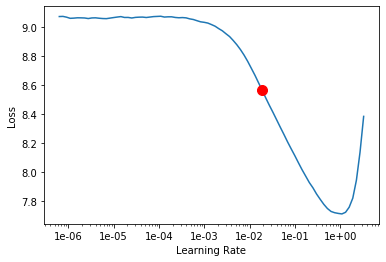

In [66]:
lm.recorder.plot(suggestion=True)

In [67]:
best_lm_lr = lm.recorder.min_grad_lr
best_lm_lr


0.019054607179632484

Start training the pre trained language model on our task-specific training and validation data set using the learning rate we managed to get

In [68]:
lm.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,6.432467,5.554783,0.186140,09:03


As you can see above, the training loss is pretty big value and the accuracy is not so good, so we try using a techinque that will enhance the fitting process.

We now try the **unfreezing** technique of the layers, and try fitting again

In [0]:
lm.unfreeze()

In [70]:
lm.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,5.172385,4.765442,0.262744,10:01


We see above that after unfreezing the layers, the training loss decreased and the accuracy increased, which means that the technique made some good enhancement in the results!

Now  we save the encoder of the weights we gained to use it with the learner object we will create then.

In [0]:
lm.save_encoder('tweets_learner')


In this part we are going to prepare the data for our classification model, by using some Fast.ai library

In [72]:


data_clf = (TextList.from_df(pd.concat([data_train, data_valid]), vocab=data_lm.vocab, cols=["normalized_tweet"]).
           split_from_df("is_valid").
           label_from_df("airline_sentiment").
           add_test(data_test["normalized_tweet"]).
           databunch()
          )

In [0]:
data_clf.save('ulmfit_data_claf_tweets')

Let’s now use the data_clf object we created earlier to build a **classifier** with our fine-tuned encoder.

In [74]:
learn_clas = text_classifier_learner(data_clf, drop_mult=0.3, arch=AWD_LSTM)
learn_clas.load_encoder('tweets_learner')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (17436 items)
x: TextList
xxbos xxunk cool,xxbos thnx info,xxbos after today no reason anyone approve merger americanair other airlines reason xxunk losing business u,xxbos get home syracuse after cancelled flightled flights one routing three us sitting charlotte,xxbos xxunk concerns really mean amp how why u keep letting people flights bags larger u state xxunk
y: CategoryList
positive,positive,negative,negative,negative
Path: .;

Valid: LabelList (4360 items)
x: TextList
xxbos your aa staff xxunk allow woman board she departure sign still now boarding,xxbos kudos phone support charlotte gate staff,xxbos hi i travel question could please follow dm you,xxbos way xxunk part it s xxunk proper systems place,xxbos ua just landed
y: CategoryList
negative,positive,neutral,negative,neutral
Path: .;

Test: LabelList (5450 items)
x: TextList
xxbos sitting denver airport waiting plane xxunk for hour half xxunk fuck united fucking xxunk,xxbos o

 <b>**The** same way as before, we try to get the best learning rate to train our model on the dataset

In [75]:
learn_clas.lr_find(start_lr=slice(10e-7, 10e-5), end_lr=slice(0.1, 10))


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.16E-04
Min loss divided by 10: 3.16E-03


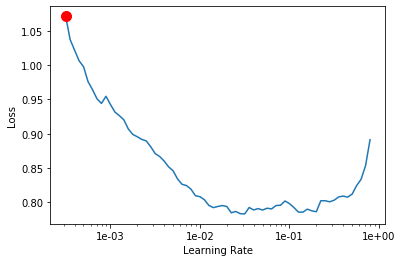

In [76]:
learn_clas.recorder.plot(skip_end=10, suggestion=True)


In [77]:
best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

0.000316227766016838

In [78]:
learn_clas.fit_one_cycle(1, best_clf_lr)


epoch,train_loss,valid_loss,accuracy,time
0,0.683163,0.713023,0.697477,08:37


Here we are trying to be wise while unfreezing the the layers, we start by unfreezing only part of it, and check the results

In [0]:
learn_clas.freeze_to(-2)


In [80]:
learn_clas.fit_one_cycle(1, best_clf_lr)


epoch,train_loss,valid_loss,accuracy,time
0,0.609941,0.603697,0.755734,09:40


Now, We unfreeze the all the layers of the model

In [0]:
learn_clas.unfreeze()


In [82]:
learn_clas.fit_one_cycle(1, best_clf_lr)


epoch,train_loss,valid_loss,accuracy,time
0,0.526984,0.496025,0.816055,10:17


As you can see above the training loss is getting lower and the accuracy is increasing.

So, we decided to increas the number of training epochs and check the results again

In [83]:
learn_clas.fit_one_cycle(3, best_clf_lr)


epoch,train_loss,valid_loss,accuracy,time
0,0.422130,0.413977,0.849541,10:29
1,0.315107,0.337129,0.884862,10:06
2,0.207419,0.314525,0.892431,11:15


The Results got much much better, this means that the more we increase the epochs the more we are getting better results 

In [0]:
 learn_clas.save_encoder('final_tweets_model')


### <b> Now, Let's proceed with part of testing our model

In [85]:
learn_clas.show_results()


text,target,prediction
xxbos xxunk u us airways with yo shitty chicken xxunk xxunk that so xxunk and u xxunk make me wait in a hr layover xxunk u and,negative,negative
xxbos better travel photos my kindle e book easy tips guide http t co dm j h m http t co xedeckgmw http t co frghglmkqf,neutral,neutral
xxbos that s cause we re trueblue it s ur love keeps xxunk xxunk https t co xxunk xxunk http t co xxunk t xxunk,neutral,negative
xxbos e xxrep 4 y cancelled flightlations flight booking problemss reflight booking problemss y all got flight tonight not tomorrow amp fc upgrade thx,positive,positive
xxbos e xxrep 4 y cancelled flightlations flight booking problemss reflight booking problemss y all got flight tonight not tomorrow amp fc upgrade thx,positive,positive


Let's add the testing data into our data_clf object and get the predictions

In [86]:
data_clf.add_test(data_test["normalized_tweet"])


In [87]:
test_preds, _ = learn_clas.get_preds(DatasetType.Test, 
                                     ordered=True)

In [0]:
test_pred_df = pd.DataFrame(test_preds.data.cpu().numpy(),
                            columns=['negative', 'neutral', 'positive'])
ulmfit_preds = pd.Series(np.argmax(test_pred_df.values, axis=1),
                        name='label').map({0: 'negative', 1: 'neutral', 2: 'positive'})

In [89]:
ulmfit_preds


0       negative
1       negative
2       negative
3        neutral
4       negative
          ...   
5445     neutral
5446    positive
5447     neutral
5448    negative
5449     neutral
Name: label, Length: 5450, dtype: object

In [90]:
data_test

,normalized_tweet,airline_sentiment
2142,sitting denver airport waiting plane refueled ...,negative
13224,ok we probably cancelled flight flights then ...,negative
2849,please provide update ua this flight stra...,negative
7894,thank what paris could arrange something,neutral
1041,change made hours for something taken secon...,negative
...,...,...
478,come abc one network channels have,neutral
11666,ha you re fun,positive
451,i flight artisanal cheese wine pairing,positive
7534,letting san fran no media rate what s deal ...,negative


####Now we prepare the results in order to be able to visualize it in a **confusion matrix** that will make the results clear

---



In [0]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]

In [0]:
predictions = ulmfit_preds.apply(sentiment2target)
predictions = predictions.tolist()
predictions =  np.array(predictions)

targets = data_test.airline_sentiment.apply(sentiment2target)
targets = np.array(targets)

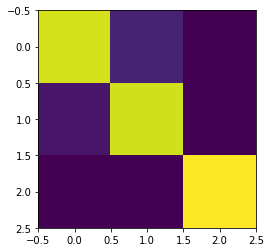

In [93]:
Confusion_Matrix =[x[:] for x in [[0] * 3] * 3]

for i in range(len(targets)):
    temp = int(targets[i])
    Confusion_Matrix[temp][predictions[i]] = Confusion_Matrix[temp][predictions[i]]+1

final = np.asarray(Confusion_Matrix)

plt.imsave("Confusion.jpg",final)



plt.imshow(Confusion_Matrix)

The confusion matrix above shows:

0 --> negative 

1 --> neutral

2 --> positive

It clearly shows the confusion among the negative and neutral instances and the perfect prediction of the positive instances

In [94]:
print("positive : ")
print(learn_clas.predict("This is a great flight I had so Much fun"))
print(learn_clas.predict("Thank you, The trip was great"))
print("negative : ")
print(learn_clas.predict("I missed My flight"))
print(learn_clas.predict("this is the worst trip I've ever had in my life"))
print(learn_clas.predict("Service was awful. I'll never fly with you again."))
print(learn_clas.predict("I lost my luggage !! Don't fly with this shitty airline again"))
print("neutral : ")
print(learn_clas.predict("I have no opinion, this flight is normal"))
print(learn_clas.predict("The flight is not bad and not good, normal"))


positive : 
(Category positive, tensor(2), tensor([0.0033, 0.0024, 0.9943]))
(Category positive, tensor(2), tensor([8.7934e-04, 1.0757e-03, 9.9804e-01]))
negative : 
(Category negative, tensor(0), tensor([0.9336, 0.0587, 0.0077]))
(Category negative, tensor(0), tensor([0.9632, 0.0026, 0.0342]))
(Category negative, tensor(0), tensor([0.9753, 0.0052, 0.0195]))
(Category negative, tensor(0), tensor([0.9859, 0.0111, 0.0030]))
neutral : 
(Category neutral, tensor(1), tensor([0.3853, 0.5344, 0.0803]))
(Category negative, tensor(0), tensor([0.9150, 0.0425, 0.0425]))


The above results assures the problem that the confusion matrix showed 

perfect predicition for the positive instances, while there is a confusion between the negative and neutral instances.

<b> We can enhance our model by many ways:</b>

1. Apply more epochs with an early stop function and get the best fitting.
2. try to gather more of the positive and neutral data instance so we have better and balanced representation of the three classes instead of using the Upsampling techinques